In [ ]:
!pip install mediapipe torch torchvision
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

### Import the necessary libraries ####

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import json
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import mediapipe as mp
import cv2
from google.colab import drive
drive.mount('/content/gdrive')

import mediapipe as mp

Mounted at /content/gdrive


### Define constants ###

In [ ]:
num_epochs = 5
lr=0.001
num_keypoints = 17

### Load the images zipped folder and extract the dataset (images)

In [ ]:
# Root path for the OCHuman shared dataset
root_dir = '/content/gdrive/My Drive/OCHuman'

# Path to the zip file in Google Drive
zip_path = os.path.join(root_dir, 'images.zip')

# Extracted images root path
images_extract_dir = '/content/gdrive/My Drive/'
images_data_root_dir = '/content/gdrive/My Drive/ochuman_images/images'

# Check if the directory exists, if not create it
if not os.path.exists(images_data_root_dir):
    os.makedirs(images_data_root_dir)
    print(f"Created directory: {images_data_root_dir}")

# Check if the directory is empty
if not os.listdir(images_data_root_dir):
    # Extract the images to another directory
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(images_extract_dir, 'ochuman_images'))
else:
    print("The directory is not empty. No extraction needed.")

# List the files in the directory after extraction
image_files = os.listdir(images_data_root_dir)

The directory is not empty. No extraction needed.


### Show total images in the dataset

In [ ]:
total_images = len(image_files)

# Print the total number of images
print("Total images in the dataset is:", total_images)

Total images in the dataset is: 5081


### Print Some Sample Images ###

In [ ]:
ochuman_json = os.path.join(root_dir, 'ochuman.json')

with open(ochuman_json) as f:
    data = json.load(f)

print(data.keys())

dict_keys(['images', 'keypoint_names', 'keypoint_visible'])


In [ ]:
images_data = data['images']

print(images_data[:2])

[{'annotations': [{'max_iou': 0.6027624011039734, 'keypoints': [302, 285, 1, 343, 390, 1, 431, 363, 1, 478, 258, 1, 577, 287, 3, 661, 282, 1, 352, 477, 1, 335, 643, 1, 307, 810, 1, 430, 486, 3, 416, 662, 1, 329, 785, 1, 353, 141, 1, 376, 244, 1, 328.49723669132726, 196.90978452976526, 1, 397.6046906555844, 184.91480238212299, 1, 371.5701271305881, 188.86769422623237, 1, 353.4413472938106, 177.5542451551607, 1, 380.9752835872622, 174.5554996182501, 1], 'segms': {'outer': [[622.1113669622191, 268.7140063205055, 635.2836803099337, 270.26369024376606, 652.3302034657997, 270.26369024376606, 662.4031489669933, 268.7140063205055, 677.1251462379686, 265.6146384739844, 691.0723015473135, 263.2901125890936, 698.8207211636163, 265.6146384739844, 703.469772933398, 273.36305809028715, 707.3439827415493, 272.5882161286569, 713.5427184345915, 273.36305809028715, 718.9666121660034, 280.3366357449596, 720.516296089264, 285.7605294763715, 718.9666121660034, 285.7605294763715, 715.092402357852, 289.63473

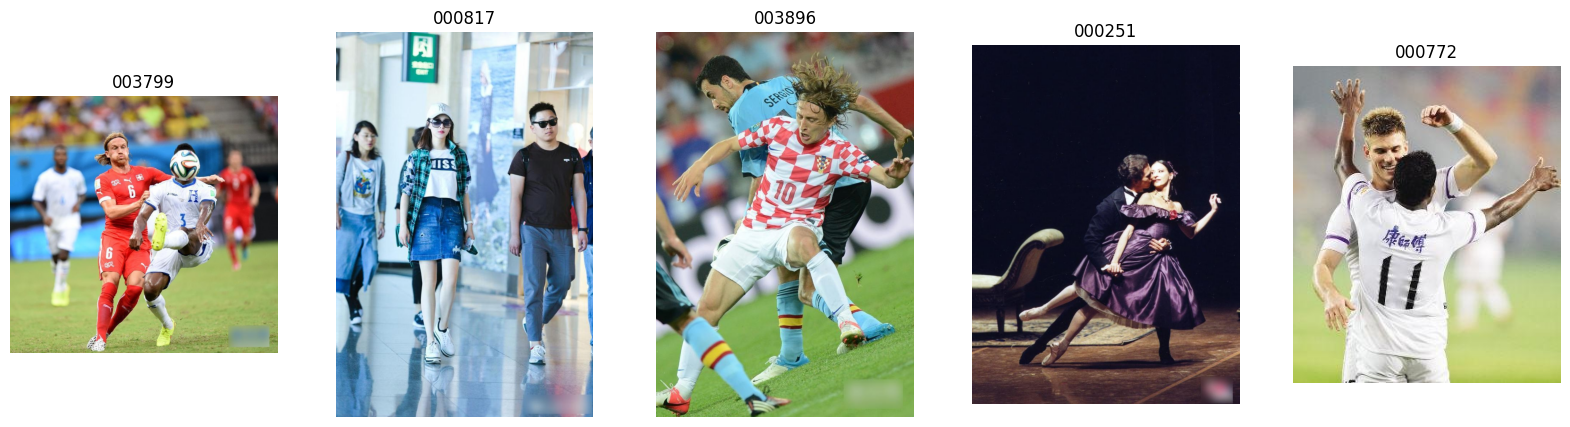

In [ ]:
def display_sample_images(image_folder, images_data, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i, entry in enumerate(images_data[:num_samples]):
        image_path = os.path.join(image_folder, entry['file_name'])
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(entry['image_id'])

        # Overlay keypoints if they are available and visible
        if 'keypoints' in entry and 'num_keypoints' in entry and entry['num_keypoints'] > 0:
            keypoints = np.array(entry['keypoints']).reshape(-1, 3)
            visible_points = keypoints[keypoints[:, 2] == 2]
            axes[i].scatter(visible_points[:, 0], visible_points[:, 1], color='red', s=10)

    plt.show()

# Call the function to display the sample images
display_sample_images(images_data_root_dir, images_data)

In [ ]:
def get_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

# Example transform: you might need to adjust depending on your model requirements
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Example function to get training data ready
def create_dataset(data, root_dir):
    images = []
    keypoints = []
    for annotation in data['annotations']:
        image_id = annotation['image_id']
        image_info = next((item for item in data['images'] if item["id"] == image_id), None)
        image_path = os.path.join(root_dir, image_info['file_name'])
        image = get_image(image_path)
        image = transform(image)
        images.append(image)
        keypoints.append(annotation['keypoints'])
    return images, keypoints


### Load annotations (validation and test)

In [ ]:
def load_annotations(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

train_annotations_path = os.path.join(root_dir, 'ochuman_coco_format_val_range_0.00_1.00.json')
test_annotations_path = os.path.join(root_dir, 'ochuman_coco_format_test_range_0.00_1.00.json')

train_data = load_annotations(train_annotations_path)
test_data = load_annotations(test_annotations_path)

# Check the structure of the data
print(train_data.keys())
print(len(train_data['images']), "training images")
print(len(train_data['annotations']), "training annotations")

dict_keys(['annotations', 'images', 'categories'])
2500 training images
4291 training annotations


### Create own dataset and data loaders ###

In [ ]:
class HumanPoseDataset(Dataset):
    def __init__(self, annotations, images_data_root_dir, transform=None):
        self.annotations = annotations['annotations']
        self.root_dir = images_data_root_dir
        self.transform = transform
        self.image_info = {image['id']: image for image in annotations['images']}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.root_dir, self.image_info[ann['image_id']]['file_name'])
        image = Image.open(image_path).convert('RGB')
        keypoints = torch.tensor(ann['keypoints'], dtype=torch.float32).view(-1, 3)  # reshape and convert to tensor

        if self.transform:
            image = self.transform(image)

        return image, keypoints[:, :2].flatten()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create dataset objects
train_dataset = HumanPoseDataset(train_data, images_data_root_dir, transform)
test_dataset = HumanPoseDataset(test_data, images_data_root_dir, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Create Neural Network Model ###

In [ ]:
class PoseEstimator(nn.Module):
    def __init__(self):
        super(PoseEstimator, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, num_keypoints * 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = PoseEstimator()


### Train the model ###

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
def train(model, train_loader, criterion, optimizer, num_epochs=num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_batches = len(train_loader)
        for i, (images, keypoints) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, keypoints)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            if i % 10 == 0:  # Print every 10 batches
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{total_batches}, Batch Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Epoch Loss: {epoch_loss:.4f}')
train(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Batch 1/269, Batch Loss: 137424.8750
Epoch 1/5, Batch 11/269, Batch Loss: 64163.7070
Epoch 1/5, Batch 21/269, Batch Loss: 46678.3008
Epoch 1/5, Batch 31/269, Batch Loss: 37456.2656
Epoch 1/5, Batch 41/269, Batch Loss: 27596.3594
Epoch 1/5, Batch 51/269, Batch Loss: 31965.8711
Epoch 1/5, Batch 61/269, Batch Loss: 29403.4922
Epoch 1/5, Batch 71/269, Batch Loss: 47815.9062
Epoch 1/5, Batch 81/269, Batch Loss: 37334.0273
Epoch 1/5, Batch 91/269, Batch Loss: 27113.9824
Epoch 1/5, Batch 101/269, Batch Loss: 41775.2617
Epoch 1/5, Batch 111/269, Batch Loss: 41719.6445
Epoch 1/5, Batch 121/269, Batch Loss: 22585.0039
Epoch 1/5, Batch 131/269, Batch Loss: 26186.9297
Epoch 1/5, Batch 141/269, Batch Loss: 25335.3359
Epoch 1/5, Batch 151/269, Batch Loss: 32453.9492
Epoch 1/5, Batch 161/269, Batch Loss: 31021.5410
Epoch 1/5, Batch 171/269, Batch Loss: 45371.0234
Epoch 1/5, Batch 181/269, Batch Loss: 32049.5703
Epoch 1/5, Batch 191/269, Batch Loss: 21004.6621
Epoch 1/5, Batch 201/269, Batc

### Evaluate the model ###

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    count = 0

    progress_bar = tqdm(total=len(test_loader.dataset), desc='Evaluating Model', unit='img')

    with torch.no_grad():
        for images, keypoints in test_loader:
            outputs = model(images)
            loss = criterion(outputs, keypoints)
            total_loss += loss.item() * images.size(0)
            count += images.size(0)

            progress_bar.update(images.size(0))

    progress_bar.close()
    average_loss = total_loss / count
    print(f"Mean Squared Error on the test set: {average_loss:.4f}")


### Run Evaluate Model ###

In [ ]:
 criterion = nn.MSELoss()
evaluate_model(model, test_loader, criterion)

Evaluating Model: 100%|██████████| 3819/3819 [03:37<00:00, 17.59img/s]

Mean Squared Error on the test set: 29401.5844


### Initialize Medipipe

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Initialize MediaPipe Pose model
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True)

def mediapipe_inference(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    results = pose.process(image)
    return results

def get_keypoints(results, image_shape):
    keypoints = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            keypoints.append((int(landmark.x * image_shape[1]), int(landmark.y * image_shape[0])))
    return keypoints


### Perfrom Pose Estimation On Sample Images ###

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def estimate_pose(image_sample):
    with mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True) as pose:
        image = cv2.imread(image_sample)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        # Draw pose annotations on the sample image
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2))

        return annotated_image, results


### Pass Sample Images to Pose Estimation ###

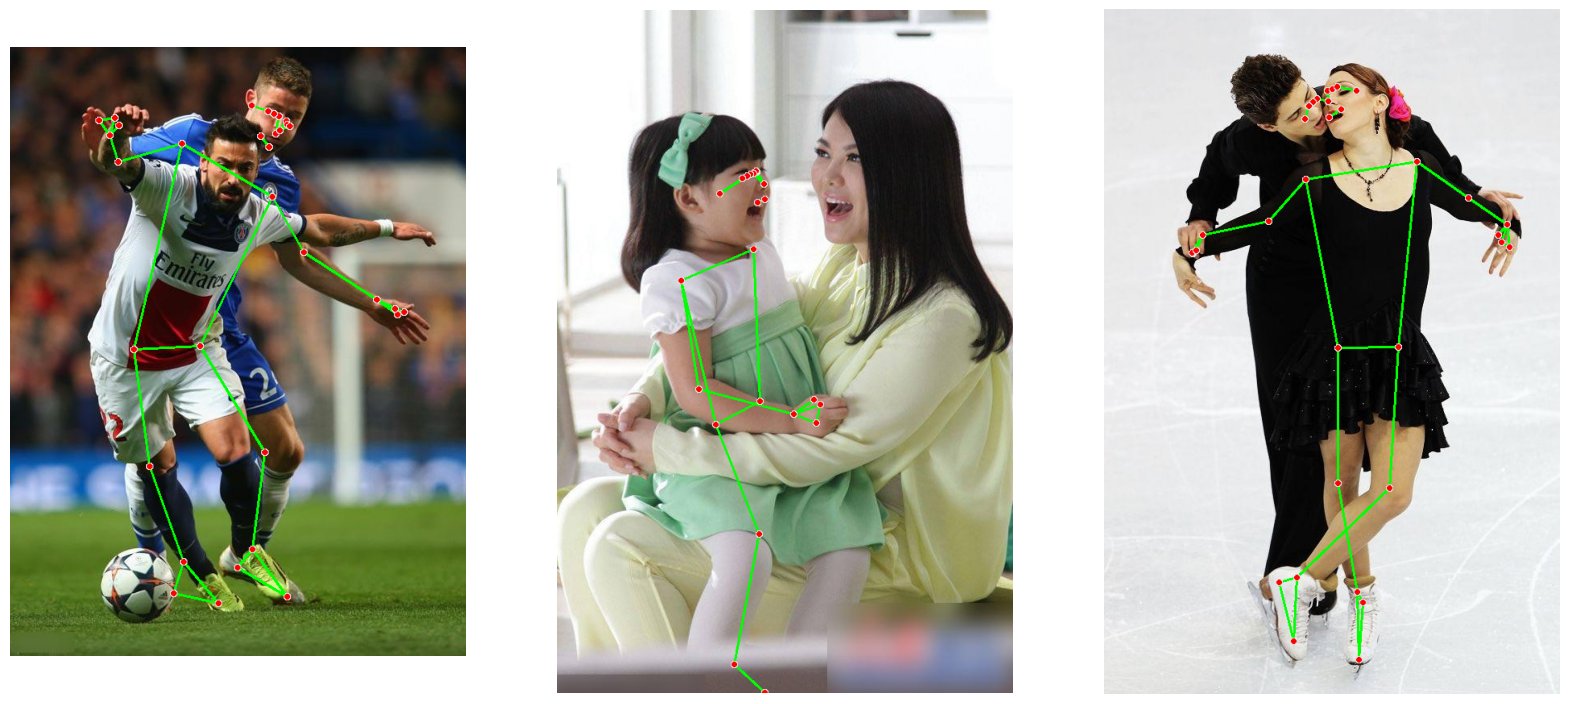

In [ ]:
image_sample = os.path.join(images_data_root_dir, '005006.jpg')
image_sample1 = os.path.join(images_data_root_dir, '001254.jpg')
image_sample2 = os.path.join(images_data_root_dir, '003254.jpg')
def process_images(image_samples):
    images = []
    for path in image_samples:
        annotated_image, _ = estimate_pose(path)
        images.append(annotated_image)
    return images

image_samples = [image_sample, image_sample1, image_sample2]
annotated_images = process_images(image_samples)

# Plot the pose estimation on sample images
plt.figure(figsize=(20, 10))
for i, img in enumerate(annotated_images):
    plt.subplot(1, len(annotated_images), i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()